In [3]:
%pip install seaborn
%pip install torchsampler

     -------------------------------------- 288.2/288.2 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 10.4/10.4 MB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 14.6/14.6 MB 6.2 MB/s eta 0:00:00
     -------------------------------------- 965.4/965.4 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 7.2 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     -------------------------------------- 163.6/163.6 kB 3.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp310-cp310-win_amd64.whl (55 kB)
     ------------------------------------- 498.1/498.1 kB 10.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached torchsampler-0.1.2-py3-none-any.whl (5.6 kB)
     ---------------------------------------- 1.1/1.1 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 167.3/167.3 MB 2.0 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ---------------------------------------- 61.5/61.5 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 140.6/140.6 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 155.3/155.3 kB 4.7 MB/s eta 0:00:00
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from io import BytesIO
import os
import copy
import glob
import cv2
import seaborn as sns
import pandas as pd
import os
import argparse
import torchsampler
import pickle
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchsampler import ImbalancedDatasetSampler
from torchvision.models import resnet50, ResNet50_Weights
import io
import torch.optim as optim



In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [3]:
#Data preprocessing
# Add flipping
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds),

  
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)

  
    ]),
    'test': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds),
  
    ]),
}

In [4]:
data_dir = 'wound_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform[x])
                  for x in ['train', 'val', 'test']}

train_loader = torch.utils.data.DataLoader(
    image_datasets['train'],
    sampler=ImbalancedDatasetSampler(image_datasets['train'])
)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], sampler = ImbalancedDatasetSampler(image_datasets[x]), batch_size=16,num_workers=3)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

In [5]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc.in_features = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimizedgo
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.9)

c:\Users\mvnsi\Desktop\train\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mvnsi\Desktop\train\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# train model function which takes the parameters of the model, criterion, optimizer, scheduler and the number of epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    # Deep copy the model
    best_model = copy.deepcopy(model.state_dict()) 
    # Current best accuracy which will be replaced
    best_acc = 0.0
    # How many iterations of training
    for epoch in range(num_epochs): 
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        last_loss = 1000
        patience = 2
        triggertimes = 0
        # Each epoch returns training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()  
            else:
                # Set model to validation mode
                model.eval()   
            #Initialize the loss
            running_loss = 0.0 
            #Initialize the correct point
            running_corrects = 0 

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward to the dataset
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward from the dataset
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if the accuracy is higher than the previous epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    # Prints the best validation accuracy and the lenght of the training
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best  weights and biases for the model to be exported
    model.load_state_dict(best_model)
    return model

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 5.0250 Acc: 0.3375
val Loss: 2.2028 Acc: 0.6125

Epoch 1/19
----------
train Loss: 1.4742 Acc: 0.7750
val Loss: 2.7779 Acc: 0.6125

Epoch 2/19
----------
train Loss: 0.4471 Acc: 0.9083
val Loss: 2.1015 Acc: 0.6250

Epoch 3/19
----------
train Loss: 0.6274 Acc: 0.8833
val Loss: 1.7169 Acc: 0.5625

Epoch 4/19
----------
train Loss: 0.3704 Acc: 0.9292
val Loss: 1.2957 Acc: 0.6375

Epoch 5/19
----------
train Loss: 0.2115 Acc: 0.9625
val Loss: 1.6684 Acc: 0.5750

Epoch 6/19
----------
train Loss: 0.2170 Acc: 0.9417
val Loss: 2.1060 Acc: 0.5500

Epoch 7/19
----------
train Loss: 0.1778 Acc: 0.9375
val Loss: 1.7401 Acc: 0.6875

Epoch 8/19
----------
train Loss: 0.0917 Acc: 0.9708
val Loss: 1.2643 Acc: 0.7125

Epoch 9/19
----------
train Loss: 0.1107 Acc: 0.9667
val Loss: 1.7834 Acc: 0.5250

Epoch 10/19
----------
train Loss: 0.0380 Acc: 0.9917
val Loss: 1.9371 Acc: 0.6250

Epoch 11/19
----------
train Loss: 0.0284 Acc: 0.9917
val Loss: 1.5059 Acc: 0.7625

Ep

Text(0.5, 80.7222222222222, 'Predicted label')

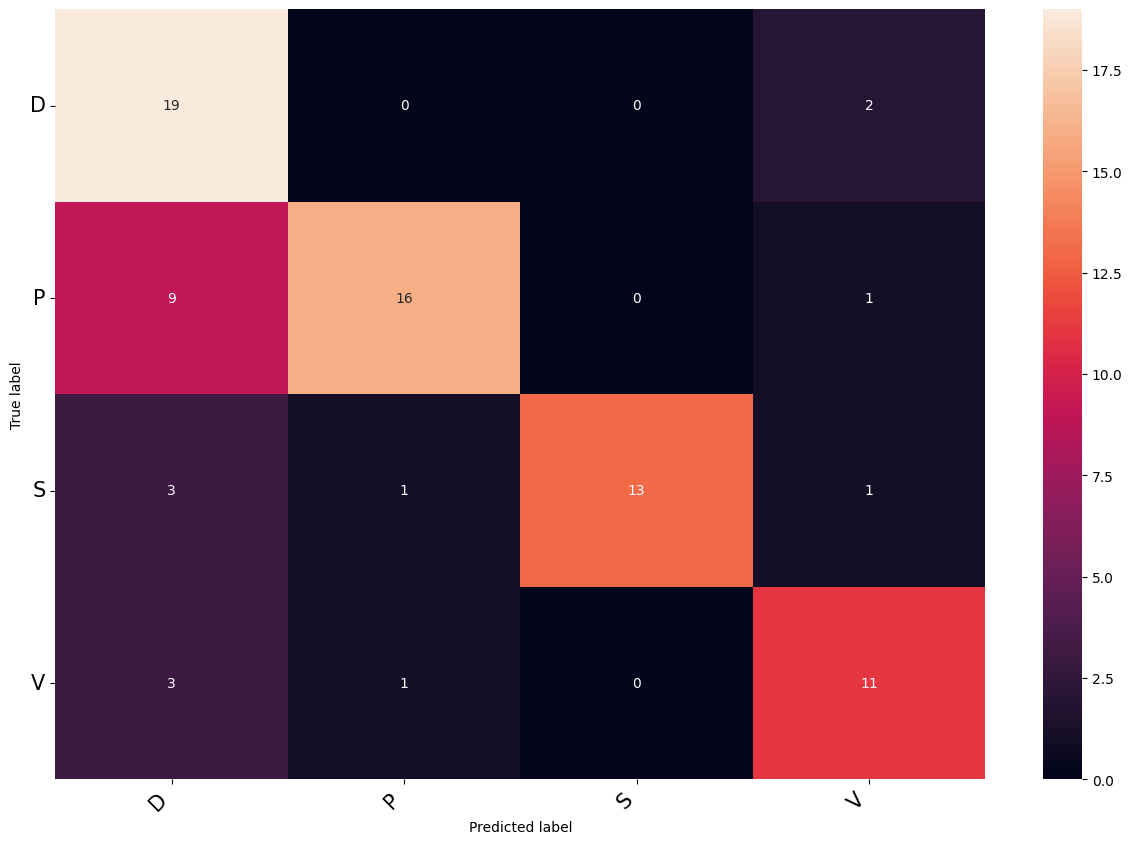

In [9]:
cm_classes = 4
confusion_matrix = np.zeros((cm_classes, cm_classes))
with torch.no_grad():
    #Loads dataset
    for i, (inputs, truelbl) in enumerate(dataloaders['val']):
        # The test dataset that will be used as the input
        inputs = inputs.to(device)
        # The actual class label
        truelbl = truelbl.to(device)
        #model prediction
        outputs = model_ft(inputs)

        _, preds = torch.max(outputs, 1)
        for t, p in zip(truelbl.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# to output the matrix size
plt.figure(figsize=(15,10))
#defining the class names to the labels
class_names = label_classes

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#using a heatmap to get better graphical analysis
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#True label
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')

#pred lable
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.xlabel('Predicted label')
plt.savefig('efficient_val_cm.png')


Text(0.5, 80.7222222222222, 'Predicted label')

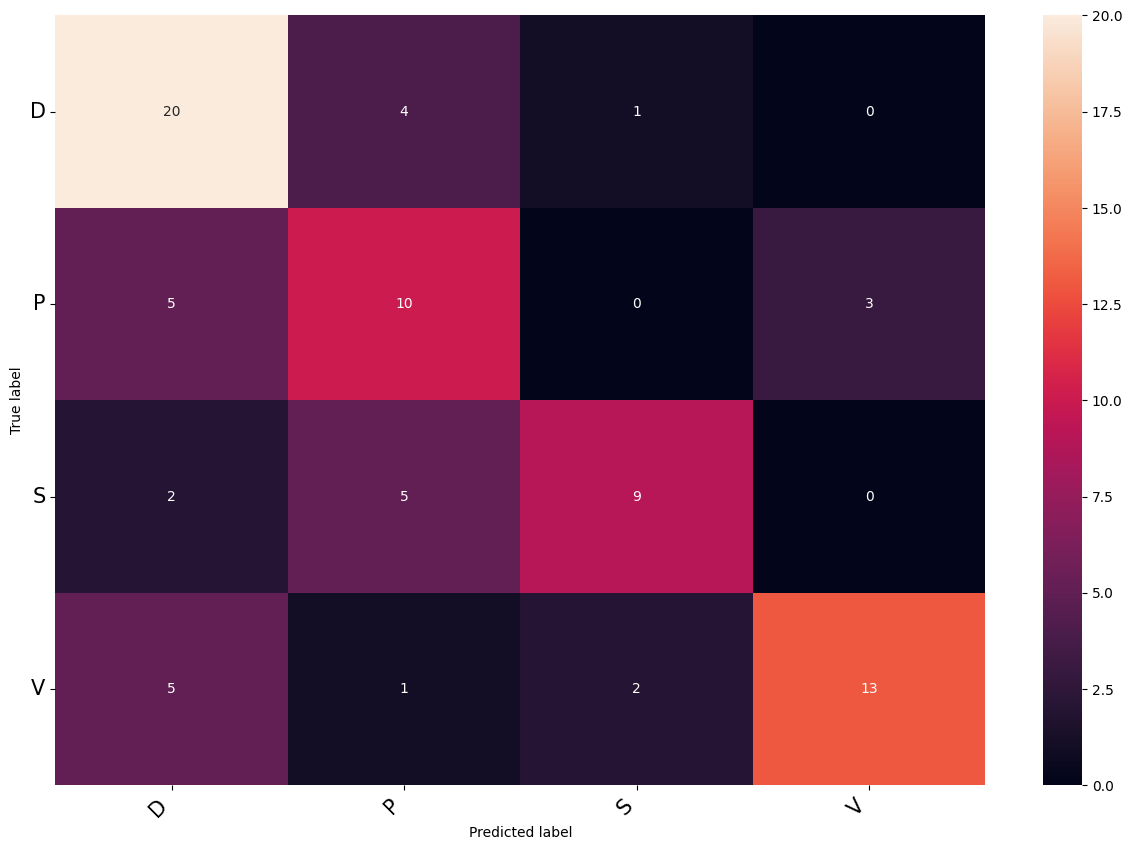

In [10]:
cm_classes = 4
confusion_matrix = np.zeros((cm_classes, cm_classes))
with torch.no_grad():
    #Loads dataset
    for i, (inputs, truelbl) in enumerate(dataloaders['test']):
        # The test dataset that will be used as the input
        inputs = inputs.to(device)
        # The actual class label
        truelbl = truelbl.to(device)
        #model prediction
        outputs = model_ft(inputs)

        _, preds = torch.max(outputs, 1)
        for t, p in zip(truelbl.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# to output the matrix size
plt.figure(figsize=(15,10))
#defining the class names to the labels
class_names = label_classes

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#using a heatmap to get better graphical analysis
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#True label
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')

#pred lable
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.xlabel('Predicted label')
plt.savefig('efficient_val_cm.png')


In [16]:
torch.save(model_ft.state_dict(), 'resnet.pt')
pickle.dump(model_ft, open('resnet.pkl','wb'))